In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
import re

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# Configuration

In [2]:
class CFG:
    root_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/")
    train_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train")
    test_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test")

## Feature definitions

In [3]:
if __name__ == '__main__':
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'max_colwidth', 400): 
        enhanced_feat_def_df = pd.read_parquet("/kaggle/input/home-credit-enhanced-feature-definitions/feature_definitions_dtypes_tables.parquet")
        display(enhanced_feat_def_df)

,Variable,Description,dtype,tables
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actual).,Float64,"[train_applprev_1_0, train_applprev_1_1]"
1,actualdpdtolerance_344P,DPD of client with tolerance.,Float64,"[train_static_0_0, train_static_0_1]"
2,addres_district_368M,District of the person's address.,String,[train_person_2]
3,addres_role_871L,Role of person's address.,String,[train_person_2]
4,addres_zip_823M,Zip code of the address.,String,[train_person_2]
5,amount_1115A,Credit amount of the active contract provided by the credit bureau.,Float64,[train_credit_bureau_b_1]
6,amount_416A,Deposit amount.,Float64,[train_deposit_1]
7,amount_4527230A,Tax deductions amount tracked by the government registry.,Float64,[train_tax_registry_a_1]
8,amount_4917619A,Tax deductions amount tracked by the government registry.,Float64,[train_tax_registry_b_1]
9,amtdebitincoming_4809443A,Incoming debit card transactions amount.,Float64,[train_other_1]


# Data collection and preprocessing

In [4]:
### from https://www.kaggle.com/code/batprem/home-credit-risk-mode-utility-scripts

def reduce_mem_usage(df, float16_as32=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Pipeline

In [5]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

# Automated aggregation

In [6]:
class Aggregator:
    def __init__(
        self, 
        num_aggregators=[pl.max, pl.min, pl.first, pl.last, pl.mean], 
        str_aggregators=[pl.max, pl.min, pl.first, pl.last],  # n_unique
        group_aggregators=[pl.max, pl.min, pl.first, pl.last],
        str_mode=True
    ):
        self.num_aggregators = num_aggregators
        self.str_aggregators = str_aggregators
        self.group_aggregators = group_aggregators
        self.str_mode=str_mode
    
    def num_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("P", "A")]
        expr_all = []
        for method in self.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]
            expr_all += expr

        return expr_all

    def date_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("D",)]
        expr_all = []
        for method in self.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    def str_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("M",)]
        
        expr_all = []
        for method in self.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
        if self.str_mode:
            expr_mode = [
                pl.col(col)
                .drop_nulls()
                .mode()
                .first()
                .alias(f"mode_{col}")
                for col in cols
            ]
        else:
            expr_mode = []

        return expr_all + expr_mode

    def other_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("T", "L")]
        
        expr_all = []
        for method in self.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all
    
    def count_expr(self, df_cols):
        cols = [col for col in df_cols if "num_group" in col]

        expr_all = []
        for method in self.group_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    def get_exprs(self, df_cols):
        exprs = (
            self.num_expr(df_cols) + 
            self.date_expr(df_cols) + 
            self.str_expr(df_cols) + 
            self.other_expr(df_cols) + 
            self.count_expr(df_cols)
        )

        return exprs

In [7]:
def read_files_by_path(pattern_path, aggregator, depth=None, agg_chunks=False, num_group1_filter=None):
    chunks = []
    for i, path in enumerate(glob(str(pattern_path))):
        print("  chunk: ", i)
        chunk = pl.read_parquet(path).pipe(Pipeline.set_table_dtypes)
        if agg_chunks:
            if num_group1_filter != None:
                chunk = chunk.filter((pl.col("num_group1") == num_group1_filter)).drop(columns=["num_group1"])
            chunk = chunk.group_by("case_id").agg(aggregator.get_exprs(chunk.columns))
        chunks.append(chunk)
    df = pl.concat(chunks, how="vertical_relaxed")
    
    if depth in [1, 2]:
        print(f"  agg, depth {depth}")
        if num_group1_filter != None:
            df = df.filter((pl.col("num_group1") == num_group1_filter)).drop(columns=["num_group1"])
        df = df.group_by("case_id").agg(aggregator.get_exprs(df.columns))
    return df

In [8]:
def read_files(files_arr, data_dir, aggregator, mode="train", agg_chunks=False, num_group1_filter=None):
    base_file_name = f"{mode}_base.parquet"
    print("  files: ", base_file_name)
    feats_df = read_files_by_path(
        data_dir / base_file_name, data_dir, mode
    )
    
    for i, file_name in enumerate(files_arr):
        depth = re.findall("\w_(\d)", file_name)
        if len(depth) > 0:
            depth = depth[0]
        else:
            continue
        print("  files: ", file_name, f"(depth: {depth})")
        files_df = read_files_by_path(
            data_dir / f"{mode}{file_name}", 
            aggregator, int(depth), agg_chunks, 
            num_group1_filter=num_group1_filter
        )
        feats_df = feats_df.join(
            files_df, 
            how="left", on="case_id", suffix=f"_{depth}_{i}"
        )
        del files_df
        gc.collect()

    return feats_df

In [9]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data

# Prepare df

In [10]:

def prepare_df(
    files_arr, data_dir, aggregator, 
    mode="train", cat_cols=None, train_cols=[], 
    agg_chunks=False, feat_eng=True, num_group1_filter=None
):
    print()
    print("Collecting data...")
    feats_df = read_files(files_arr, data_dir, aggregator, mode=mode, agg_chunks=agg_chunks)
    print("  feats_df shape:\t", feats_df.shape)
    
    if feat_eng:
        print("Feature Engineering...")
        feats_df = feats_df.with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
        neworder = feats_df.columns
        neworder.remove("month_decision")
        neworder.remove("weekday_decision")
        neworder.insert(5, "month_decision")
        neworder.insert(6, "weekday_decision")
        feats_df = feats_df.select(neworder)
    
    feats_df = feats_df.pipe(Pipeline.handle_dates)
#     print("  feats_df shape:\t", feats_df.shape)
    
    print("Filter cols...")
    if mode == "train":
        feats_df = feats_df.pipe(Pipeline.filter_cols)
    else:
        train_cols = feats_df.columns if len(train_cols) == 0 else train_cols
        feats_df = feats_df.select([col for col in train_cols if col != "target"])
    print("  feats_df shape:\t", feats_df.shape)
    
    print("Convert to pandas...")
    feats_df = to_pandas(feats_df, cat_cols)
    return feats_df

In [11]:
credit_bureau_a_1_files = [
    "_credit_bureau_a_1_*.parquet",
]
credit_b_a_1_agg = Aggregator(
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean],
    str_aggregators = [pl.max, pl.min, pl.first, pl.last], # n_unique
    group_aggregators = [pl.max, pl.min, pl.first, pl.last]
)

In [12]:
if __name__ == '__main__':
    credit_bureau_a_1_train_df = prepare_df(
        credit_bureau_a_1_files, CFG.train_dir, credit_b_a_1_agg, feat_eng=False
    )
    gc.collect()
    cat_cols_credit_bureau_a_1 = list(credit_bureau_a_1_train_df.select_dtypes("category").columns)
    display(credit_bureau_a_1_train_df)



  files:  train_base.parquet
  chunk:  0
  files:  _credit_bureau_a_1_*.parquet (depth: 1)
  chunk:  0
  chunk:  1
  chunk:  2
  chunk:  3
  agg, depth 1
  feats_df shape:	 (1526659, 366)
Filter cols...
  feats_df shape:	 (1526659, 288)
Convert to pandas...


,case_id,WEEK_NUM,target,max_credlmt_230A,max_credlmt_935A,max_debtoutstand_525A,max_debtoverdue_47A,max_dpdmax_139P,max_dpdmax_757P,max_instlamount_768A,max_instlamount_852A,max_monthlyinstlamount_332A,max_monthlyinstlamount_674A,max_outstandingamount_354A,max_outstandingamount_362A,max_overdueamount_31A,max_overdueamount_659A,max_overdueamountmax2_14A,max_overdueamountmax2_398A,max_overdueamountmax_155A,max_overdueamountmax_35A,max_residualamount_488A,max_residualamount_856A,max_totalamount_6A,max_totalamount_996A,max_totaldebtoverduevalue_178A,max_totaldebtoverduevalue_718A,max_totaloutstanddebtvalue_39A,max_totaloutstanddebtvalue_668A,min_credlmt_230A,min_credlmt_935A,min_debtoutstand_525A,min_debtoverdue_47A,min_dpdmax_139P,min_dpdmax_757P,min_instlamount_768A,min_instlamount_852A,min_monthlyinstlamount_332A,min_monthlyinstlamount_674A,min_outstandingamount_354A,min_outstandingamount_362A,min_overdueamount_31A,min_overdueamount_659A,min_overdueamountmax2_14A,min_overdueamountmax2_398A,min_overdueamountmax_155A,min_overdueamountmax_35A,min_residualamount_488A,min_residualamount_856A,min_totalamount_6A,min_totalamount_996A,min_totaldebtoverduevalue_178A,min_totaldebtoverduevalue_718A,min_totaloutstanddebtvalue_39A,min_totaloutstanddebtvalue_668A,first_credlmt_230A,first_credlmt_935A,first_debtoutstand_525A,first_debtoverdue_47A,first_dpdmax_139P,first_dpdmax_757P,first_instlamount_768A,first_instlamount_852A,first_monthlyinstlamount_332A,first_monthlyinstlamount_674A,first_outstandingamount_354A,first_outstandingamount_362A,first_overdueamount_31A,first_overdueamount_659A,first_overdueamountmax2_14A,first_overdueamountmax2_398A,first_overdueamountmax_155A,first_overdueamountmax_35A,first_residualamount_488A,first_residualamount_856A,first_totalamount_6A,first_totalamount_996A,first_totaldebtoverduevalue_178A,first_totaldebtoverduevalue_718A,first_totaloutstanddebtvalue_39A,first_totaloutstanddebtvalue_668A,mean_credlmt_230A,mean_credlmt_935A,mean_debtoutstand_525A,mean_debtoverdue_47A,mean_dpdmax_139P,mean_dpdmax_757P,mean_instlamount_768A,mean_instlamount_852A,mean_monthlyinstlamount_332A,mean_monthlyinstlamount_674A,mean_outstandingamount_354A,mean_outstandingamount_362A,mean_overdueamount_31A,mean_overdueamount_659A,mean_overdueamountmax2_14A,mean_overdueamountmax2_398A,mean_overdueamountmax_155A,mean_overdueamountmax_35A,mean_residualamount_488A,mean_residualamount_856A,mean_totalamount_6A,mean_totalamount_996A,mean_totaldebtoverduevalue_178A,mean_totaldebtoverduevalue_718A,mean_totaloutstanddebtvalue_39A,mean_totaloutstanddebtvalue_668A,max_dateofcredend_289D,max_dateofcredend_353D,max_dateofcredstart_181D,max_dateofcredstart_739D,max_dateofrealrepmt_138D,max_lastupdate_1112D,max_lastupdate_388D,max_numberofoverdueinstlmaxdat_148D,max_numberofoverdueinstlmaxdat_641D,max_overdueamountmax2date_1002D,max_overdueamountmax2date_1142D,max_refreshdate_3813885D,min_dateofcredend_289D,min_dateofcredend_353D,min_dateofcredstart_181D,min_dateofcredstart_739D,min_dateofrealrepmt_138D,min_lastupdate_1112D,min_lastupdate_388D,min_numberofoverdueinstlmaxdat_148D,min_numberofoverdueinstlmaxdat_641D,min_overdueamountmax2date_1002D,min_overdueamountmax2date_1142D,min_refreshdate_3813885D,first_dateofcredend_289D,first_dateofcredend_353D,first_dateofcredstart_181D,first_dateofcredstart_739D,first_dateofrealrepmt_138D,first_lastupdate_1112D,first_lastupdate_388D,first_numberofoverdueinstlmaxdat_148D,first_numberofoverdueinstlmaxdat_641D,first_overdueamountmax2date_1002D,first_overdueamountmax2date_1142D,first_refreshdate_3813885D,last_refreshdate_3813885D,mean_dateofcredend_289D,mean_dateofcredend_353D,mean_dateofcredstart_181D,mean_dateofcredstart_739D,mean_dateofrealrepmt_138D,mean_lastupdate_1112D,mean_lastupdate_388D,mean_numberofoverdueinstlmaxdat_148D,mean_numberofoverdueinstlmaxdat_641D,mean_overdueamountmax2date_1002D,mean_overdueamountmax2date_1142D,mean_refreshdate_3813885D,max_classificationofcontr_13M,max_classificationofcontr

In [13]:
credit_bureau_a_2_files = [
    "_credit_bureau_a_2_*.parquet",
]
credit_b_a_2_agg = Aggregator(
    num_aggregators = [pl.first],
    str_aggregators = [pl.first],
    group_aggregators = [pl.first],
    str_mode = False
)
credit_b_a_2_agg_2 = Aggregator(
    num_aggregators = [pl.max],
    str_aggregators = [pl.max],
    group_aggregators = [pl.max],
    str_mode = False
)

In [14]:
if __name__ == '__main__':
    credit_bureau_a_2_train_df = prepare_df(
        credit_bureau_a_2_files, CFG.train_dir, credit_b_a_2_agg, agg_chunks=True, feat_eng=False
    )
    
    credit_bureau_a_2_train_df_2 = prepare_df(
        credit_bureau_a_2_files, CFG.train_dir, credit_b_a_2_agg_2, agg_chunks=True, feat_eng=False
    )
    credit_bureau_a_2_train_df_2.set_index("case_id", inplace=True)
    
    credit_bureau_a_2_train_df = credit_bureau_a_2_train_df.join(
        credit_bureau_a_2_train_df_2.drop(columns=["WEEK_NUM", "target"]), 
        how="left", on="case_id"
    )
    
    cat_cols_credit_bureau_a_2 = list(credit_bureau_a_2_train_df.select_dtypes("category").columns)
    del credit_bureau_a_2_train_df_2
    gc.collect()
    display(credit_bureau_a_2_train_df)



  files:  train_base.parquet
  chunk:  0
  files:  _credit_bureau_a_2_*.parquet (depth: 2)
  chunk:  0
  chunk:  1
  chunk:  2
  chunk:  3
  chunk:  4
  chunk:  5
  chunk:  6
  chunk:  7
  chunk:  8
  chunk:  9
  chunk:  10
  agg, depth 2
  feats_df shape:	 (1526659, 23)
Filter cols...
  feats_df shape:	 (1526659, 19)
Convert to pandas...

  files:  train_base.parquet
  chunk:  0
  files:  _credit_bureau_a_2_*.parquet (depth: 2)
  chunk:  0
  chunk:  1
  chunk:  2
  chunk:  3
  chunk:  4
  chunk:  5
  chunk:  6
  chunk:  7
  chunk:  8
  chunk:  9
  chunk:  10
  agg, depth 2
  feats_df shape:	 (1526659, 23)
Filter cols...
  feats_df shape:	 (1526659, 21)
Convert to pandas...


,case_id,WEEK_NUM,target,first_first_pmts_dpd_1073P,first_first_pmts_overdue_1140A,first_first_collater_typofvalofguarant_298M,first_first_collater_typofvalofguarant_407M,first_first_collaterals_typeofguarante_359M,first_first_collaterals_typeofguarante_669M,first_first_subjectroles_name_541M,first_first_subjectroles_name_838M,first_first_collater_valueofguarantee_1124L,first_first_collater_valueofguarantee_876L,first_first_pmts_month_158T,first_first_pmts_month_706T,first_first_pmts_year_1139T,first_first_pmts_year_507T,first_first_num_group1,first_first_num_group2,max_max_pmts_dpd_1073P,max_max_pmts_dpd_303P,max_max_pmts_overdue_1140A,max_max_pmts_overdue_1152A,max_max_collater_typofvalofguarant_298M,max_max_collater_typofvalofguarant_407M,max_max_collaterals_typeofguarante_359M,max_max_collaterals_typeofguarante_669M,max_max_subjectroles_name_541M,max_max_subjectroles_name_838M,max_max_collater_valueofguarantee_1124L,max_max_collater_valueofguarantee_876L,max_max_pmts_month_158T,max_max_pmts_month_706T,max_max_pmts_year_1139T,max_max_pmts_year_507T,max_max_num_group1,max_max_num_group2
0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,91,0,NaN,NaN,9a0c095e,9a0c095e,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2018.0,2006.0,0.0,0.0,0.0,44.0,0.0000,4316.44,a55475b1,a55475b1,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2021.0,10.0,35.0
1526655,2703451,91,0,NaN,NaN,9a0c095e,9a0c095e,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2019.0,2015.0,0.0,0.0,0.0,0.0,0.0000,0.00,a55475b1,a55475b1,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2021.0,3.0,23.0
1526656,2703452,91,0,NaN,NaN,9a0c095e,9a0c095e,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2018.0,2012.0,0.0,0.0,16.0,0.0,4884.2983,0.00,a55475b1,a55475b1,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2020.0,2.0,35.0
1526657,2703453,91,0,NaN,NaN,9a0c095e,8fd95e4b,3cbe86ba,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,2.0,2.0,2019.0,2008.0,0.0,0.0,0.0,23.0,0.0000,2693.20,a55475b1,a55475b1,c7a5ad39,c7a5ad39,ab3c25cf,ab3c25cf,0.0,0.0,12.0,12.0,2021.0,2020.0,12.0,35.0


In [15]:
if __name__ == '__main__':
    display(credit_bureau_a_2_train_df.describe())

,case_id,WEEK_NUM,target,first_first_pmts_dpd_1073P,first_first_pmts_overdue_1140A,first_first_collater_valueofguarantee_1124L,first_first_collater_valueofguarantee_876L,first_first_pmts_month_158T,first_first_pmts_month_706T,first_first_pmts_year_1139T,first_first_pmts_year_507T,first_first_num_group1,first_first_num_group2,max_max_pmts_dpd_1073P,max_max_pmts_dpd_303P,max_max_pmts_overdue_1140A,max_max_pmts_overdue_1152A,max_max_collater_valueofguarantee_1124L,max_max_collater_valueofguarantee_876L,max_max_pmts_month_158T,max_max_pmts_month_706T,max_max_pmts_year_1139T,max_max_pmts_year_507T,max_max_num_group1,max_max_num_group2
count,1.526659e+06,1.526659e+06,1.526659e+06,86871.000000,8.708200e+04,1.264000e+06,1.005365e+06,1.264006e+06,1.011554e+06,1.264006e+06,1.011554e+06,1.385288e+06,1.385288e+06,1.263493e+06,1.012589e+06,1.264006e+06,1.012672e+06,1.264000e+06,1.013775e+06,1264006.0,1014061.0,1.264006e+06,1.014061e+06,1.385288e+06,1.385288e+06
mean,1.286077e+06,4.076904e+01,3.143728e-02,11.023253,1.379000e+03,8.900942e+04,4.324896e+05,2.006024e+00,2.005442e+00,2.017913e+03,2.011686e+03,1.356361e-01,6.083212e-03,2.340839e+01,2.226359e+02,5.567941e+03,2.224089e+04,1.466330e+06,4.194532e+06,12.0,12.0,2.020271e+03,2.019255e+03,4.471963e+00,3.170512e+01
std,7.189466e+05,2.379798e+01,1.744964e-01,121.841748,6.383681e+04,1.583970e+06,2.287902e+07,8.687661e-02,8.612403e-02,8.114835e-01,4.356577e+00,4.692805e-01,9.021195e-02,1.778041e+02,1.003359e+03,5.670859e+05,7.278208e+05,9.808360e+07,1.386306e+08,0.0,0.0,4.694997e-01,1.982336e+00,5.805309e+00,6.225590e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.015000e+03,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,12.0,12.0,2.018000e+03,2.004000e+03,0.000000e+00,0.000000e+00
25%,7.661975e+05,2.300000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.017000e+03,2.007000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,12.0,12.0,2.020000e+03,2.019000e+03,1.000000e+00,3.500000e+01
50%,1.357358e+06,4.000000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.018000e+03,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,3.016394e+03,0.000000e+00,0.000000e+00,12.0,12.0,2.020000e+03,2.020000e+03,2.000000e+00,3.500000e+01
75%,1.739022e+06,5.500000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.018000e+03,2.016000e+03,0.000000e+00,0.000000e+00,2.000000e+00,7.600000e+01,1.694991e+03,1.141508e+04,0.000000e+00,3.350000e+04,12.0,12.0,2.021000e+03,2.020000e+03,6.000000e+00,3.500000e+01
max,2.703454e+06,9.100000e+01,1.000000e+00,3685.000000,1.736279e+07,7.714286e+08,3.250000e+09,1.200000e+01,1.200000e+01,2.020000e+03,2.020000e+03,7.000000e+01,1.400000e+01,4.877000e+03,6.574580e+05,4.373397e+08,5.934650e+08,9.878000e+10,9.878000e+10,12.0,12.0,2.021000e+03,2.028000e+03,3.320000e+02,1.000000e+02


In [16]:
if __name__ == '__main__':
    display(credit_bureau_a_2_train_df[credit_bureau_a_2_train_df.case_id == 405])

,case_id,WEEK_NUM,target,first_first_pmts_dpd_1073P,first_first_pmts_overdue_1140A,first_first_collater_typofvalofguarant_298M,first_first_collater_typofvalofguarant_407M,first_first_collaterals_typeofguarante_359M,first_first_collaterals_typeofguarante_669M,first_first_subjectroles_name_541M,first_first_subjectroles_name_838M,first_first_collater_valueofguarantee_1124L,first_first_collater_valueofguarantee_876L,first_first_pmts_month_158T,first_first_pmts_month_706T,first_first_pmts_year_1139T,first_first_pmts_year_507T,first_first_num_group1,first_first_num_group2,max_max_pmts_dpd_1073P,max_max_pmts_dpd_303P,max_max_pmts_overdue_1140A,max_max_pmts_overdue_1152A,max_max_collater_typofvalofguarant_298M,max_max_collater_typofvalofguarant_407M,max_max_collaterals_typeofguarante_359M,max_max_collaterals_typeofguarante_669M,max_max_subjectroles_name_541M,max_max_subjectroles_name_838M,max_max_collater_valueofguarantee_1124L,max_max_collater_valueofguarantee_876L,max_max_pmts_month_158T,max_max_pmts_month_706T,max_max_pmts_year_1139T,max_max_pmts_year_507T,max_max_num_group1,max_max_num_group2
405,405,1,0,0.0,0.0,9a0c095e,a55475b1,a55475b1,c7a5ad39,a55475b1,ab3c25cf,0.0,NaN,2.0,NaN,2017.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,a55475b1,a55475b1,a55475b1,c7a5ad39,a55475b1,ab3c25cf,0.0,NaN,12.0,NaN,2020.0,NaN,1.0,35.0


In [17]:
base_files = [
    "_static_cb_0.parquet",
    "_static_0_*.parquet",
    "_applprev_1_*.parquet",
    "_tax_registry_a_1.parquet",
    "_tax_registry_b_1.parquet",
    "_tax_registry_c_1.parquet",
    "_other_1.parquet",
    "_person_1.parquet",
    "_deposit_1.parquet",
    "_debitcard_1.parquet",
    "_credit_bureau_b_1.parquet",
    "_credit_bureau_b_2.parquet",
]
base_agg = Aggregator(
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean],
    str_aggregators = [pl.max, pl.min, pl.first, pl.last],
    group_aggregators = [pl.max, pl.min, pl.first, pl.last],
    str_mode = True
)

In [18]:
if __name__ == '__main__':
    train_base_df = prepare_df(base_files, CFG.train_dir, base_agg)
    cat_cols_base = list(train_base_df.select_dtypes("category").columns)
    display(train_base_df)


  files:  train_base.parquet
  chunk:  0
  files:  _static_cb_0.parquet (depth: 0)
  chunk:  0
  files:  _static_0_*.parquet (depth: 0)
  chunk:  0
  chunk:  1
  files:  _applprev_1_*.parquet (depth: 1)
  chunk:  0
  chunk:  1
  agg, depth 1
  files:  _tax_registry_a_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _tax_registry_b_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _tax_registry_c_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _other_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _person_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _deposit_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _debitcard_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _credit_bureau_b_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _credit_bureau_b_2.parquet (depth: 2)
  chunk:  0
  agg, depth 2
  feats_df shape:	 (1526659, 927)
Feature Engineering...
Filter cols...
  feats_df shape:	 (1526659, 517)
Convert to p

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_60

In [19]:
if __name__ == '__main__':
    display(cat_cols_base)

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_cancelreason_3545846M',
 'max_education_1138M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'min_cancelreason_3545846M',
 'min_education_1138M',
 'min_postype_4733339M',
 'min_rejectreason_755M',
 'min_rejectreasonclient_4145042M',
 'first_cancelreason_3545846M',
 'first_education_1138M',
 'first_postype_4733339M',
 'first_rejectreason_755M',
 'first_rejectreas

In [20]:
if __name__ == '__main__':
    test_base_df = prepare_df(
        base_files, CFG.test_dir, base_agg, mode="test", cat_cols=cat_cols_base, train_cols=train_base_df.columns
    )
    display(test_base_df)


  files:  test_base.parquet
  chunk:  0
  files:  _static_cb_0.parquet (depth: 0)
  chunk:  0
  files:  _static_0_*.parquet (depth: 0)
  chunk:  0
  chunk:  1
  chunk:  2
  files:  _applprev_1_*.parquet (depth: 1)
  chunk:  0
  chunk:  1
  chunk:  2
  agg, depth 1
  files:  _tax_registry_a_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _tax_registry_b_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _tax_registry_c_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _other_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _person_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _deposit_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _debitcard_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _credit_bureau_b_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _credit_bureau_b_2.parquet (depth: 2)
  chunk:  0
  agg, depth 2
  feats_df shape:	 (10, 926)
Feature Engineering...
Filter cols...
  feats_df shape:	 (10, 516)

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,type

# Save files

In [21]:
if __name__ == '__main__':
    train_base_df.to_parquet("train_base.parquet")
    credit_bureau_a_1_train_df.to_parquet("credit_bureau_a_1_train_df.parquet")
    credit_bureau_a_2_train_df.to_parquet("credit_bureau_a_2_train_df.parquet")

## EDA

In [22]:
if __name__ == '__main__':
    print("Train is duplicated:\t", train_base_df["case_id"].duplicated().any())
    print("Train Week Range:\t", (train_base_df["WEEK_NUM"].min(), train_base_df["WEEK_NUM"].max()))

    print()

    print("Test is duplicated:\t", test_base_df["case_id"].duplicated().any())
    print("Test Week Range:\t", (test_base_df["WEEK_NUM"].min(), test_base_df["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (100, 100)


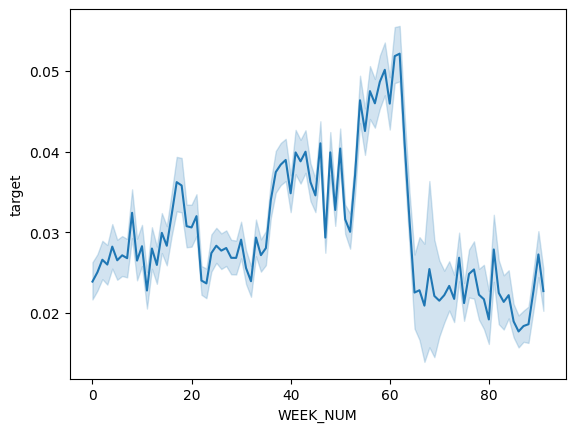

In [23]:
if __name__ == '__main__':
    sns.lineplot(
        data=train_base_df,
        x="WEEK_NUM",
        y="target",
    )
    plt.show()